In [1]:
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy as hc
from scipy.spatial.distance import pdist, squareform

from IPython.display import Javascript
from string import Template

from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import OPTICS, FeatureAgglomeration
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score

import altair as alt
alt.renderers.enable("default")
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

In [104]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
%%HTML
    <script src="https://d3js.org/d3.v5.min.js"></script>

In [3]:
%%javascript
    var script = document.createElement('script');
    script.type = 'text/javascript';
    script.src = '//d3js.org/d3.v5.min.js';
    document.head.appendChild(script);
    console.log(window.d3)

<IPython.core.display.Javascript object>

In [98]:
crime_dataset = pd.read_csv("data/communities.csv")
crime_df = crime_dataset.drop(["state","county","community","communityname","fold"], axis=1)
crime_df = crime_df.replace({"?":np.nan})
imputer = SimpleImputer()
crime_df = pd.DataFrame(imputer.fit_transform(crime_df), columns = crime_df.columns)

In [4]:
auto_dataset = pd.read_csv("data/auto_mpg.csv")
auto_df = auto_dataset.drop("car name", axis=1)
auto_df = auto_df.replace({"?":np.nan})
imputer = SimpleImputer()
auto_df = pd.DataFrame(imputer.fit_transform(auto_df), columns = auto_df.columns)

In [6]:
bike_dataset = pd.read_csv("data/bike.csv")
bike_df = bike_dataset.drop(["instant", "casual", "registered", "workingday", "dteday"], axis=1)

#de-normalize data to produce human-readable features.
#Original range info from http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
bike_df["hum"] = bike_df["hum"].apply(lambda x: x*100.)
bike_df["windspeed"] = bike_df["windspeed"].apply(lambda x: x*67.)
#convert Celsius to Fahrenheit
bike_df["temp"] = bike_df["temp"].apply(lambda x: (x*47. - 8)*9/5 +32)
bike_df["atemp"] = bike_df["atemp"].apply(lambda x: (x*66. - 16)*9/5 + 32)

bike_df = pd.get_dummies(bike_df, prefix=["weathersit"], columns=["weathersit"], drop_first = True)

#rename features to make them interpretable for novice users
bike_feature_names_dict = {
    "cnt":"Ridership",
    "yr":"First or Second Year", 
    "season":"Season", 
    "mnth": "Month",
    "hr":"Hour of Day", 
    "holiday":"Holiday",
    "weekday":"Week Day",
    "weathersit_2":"Misty Weather",
    "weathersit_3":"Light Precipitation",
    "weathersit_4":"Heavy Precipitation",
    "temp":"Temperature (F)",
    "atemp":"Feels Like (F)",
    "hum":"Humidity",
    "windspeed":"Wind Speed"
}
bike_df = bike_df.rename(mapper=bike_feature_names_dict,axis=1) 

In [7]:
breast_cancer_columns = pd.read_table("data/breast_cancer_field_names.txt", names=["features"])["features"].tolist()
breast_cancer_dataset = pd.read_csv("data/breast_cancer.csv", names=breast_cancer_columns)
breast_cancer_df = breast_cancer_dataset.drop("ID", axis=1)
breast_cancer_df["diagnosis"] = np.where(
    breast_cancer_df["diagnosis"] == "M",
    1,
    0
)

In [8]:
boston_dataset = datasets.load_boston()
boston_df = pd.DataFrame(boston_dataset.data, columns = boston_dataset.feature_names)
boston_df["Median_Home_Value"] = boston_dataset.target*1000.

In [9]:
cancer_dataset = pd.read_csv("data/cervical_cancer.csv")
cancer_df = cancer_dataset.drop("Person", axis=1)

In [10]:
cancer_age_corrected_df = cancer_df.copy()
cancer_age_corrected_df["Smokes (years)"] = cancer_age_corrected_df["Smokes (years)"]/cancer_age_corrected_df["Age"]
cancer_age_corrected_df["Hormonal Contraceptives (years)"] = cancer_age_corrected_df["Hormonal Contraceptives (years)"]/cancer_age_corrected_df["Age"]
cancer_age_corrected_df["IUD (years)"] = cancer_age_corrected_df["IUD (years)"]/cancer_age_corrected_df["Age"]
cancer_age_corrected_df["Num of pregnancies"] = cancer_age_corrected_df["Num of pregnancies"]/(cancer_age_corrected_df["Age"])

In [218]:
def visualize_feature_correlation(data, chart_type, target_name = None):
    df = data.copy()
    corr = np.round(df.corr(),2)
    if target_name is not None:
        target_corr = np.abs(corr.rename({target_name:"target_corr"}, axis=1)["target_corr"])
        df = df.drop(target_name, axis=1)
        corr = corr.drop(target_name, axis=1).drop(target_name, axis=0)
    feature_order = sorted(list(df.columns))
    if chart_type == "SPLOM":
        chart = alt.Chart(df).mark_circle().encode(
            alt.X(alt.repeat("column"), type='quantitative'),
            alt.Y(alt.repeat("row"), type='quantitative')
        ).properties(
            width=100,
            height=100
        ).repeat(
            row=list(df.columns),
            column=list(df.columns)
        )
        return chart
    elif chart_type == "dendrogram":
#     corr_condensed = hc.distance.squareform(1 - np.abs(cancer_df.corr()) ) # convert to condensed
#     z = hc.linkage(corr_condensed, method='average')
#     dendrogram_order = hc.dendrogram(z, labels=cancer_df.columns)["ivl"]      
        fig = ff.create_dendrogram(
            1 - np.abs(corr), 
            labels = df.columns
        )
        fig.update_layout(width=800, height=500)
        fig.show()
    elif chart_type == "punchcard":
        heatmap_data = corr.reset_index(drop = False).melt(id_vars="index")
        base = alt.Chart(
            heatmap_data
        ).encode(
            x = alt.X("index", sort = feature_order, axis=None),
            y = alt.Y("variable", sort = feature_order, axis=None)
        ).transform_calculate(
            abs_val = 'abs(datum.value)',
            positive_corr = 'datum.value > 0'
        ).transform_lookup(
            lookup='index',
            from_=alt.LookupData(
                data=pd.DataFrame(feature_order).reset_index(drop=False).rename({"index":"order_X", 0:"feature"}, axis=1),
                key='feature',
                fields=['order_X']
            )
        ).transform_lookup(
            lookup='variable',
            from_=alt.LookupData(
                data=pd.DataFrame(feature_order).reset_index(drop=False).rename({"index":"order_Y", 0:"feature"}, axis=1),
                key='feature',
                fields=['order_Y']
            )
        ).properties(
            width = 700,
            height = 500
        )

        circles = base.mark_circle().encode(
            color = "positive_corr:N",
            size = alt.condition(
                "datum.order_Y >= datum.order_X",
                alt.value(0),
                alt.Size(
                    "abs_val:Q", 
                    scale=alt.Scale(range=[0,2000], domain=[0,1])
                )
            )
        )
        text = base.mark_text(align="right").encode(
            text = "index",
            opacity = alt.condition("datum.order_Y == datum.order_X", alt.value(1), alt.value(0))
        )
        return (text+circles).resolve_scale(y = "shared", x="shared")
    elif chart_type == "heatmap":
        heatmap_data = corr.reset_index(drop = False).melt(id_vars="index")
        base = alt.Chart(
            heatmap_data
        ).encode(
            x = alt.X("index", sort = feature_order, axis = alt.Axis(labelAngle=15)),
            y = alt.Y("variable", sort = feature_order)
        ).transform_calculate(
            abs_val = 'abs(datum.value)'
        ).properties(
            width = 700,
            height = 500
        )

        rects = base.mark_rect().encode(
            color = alt.Color("abs_val:Q", scale=alt.Scale(domain=[0,1])),
        )
        text = base.mark_text(align="center").encode(
            text = "value",
            color = alt.condition(
                "datum.value < .5",
                alt.value("black"),
                alt.value("white")
            )
        )
        return (rects+text).resolve_scale(y = "shared", x="shared")
    elif chart_type == "clusters":
        
        #compute PCA and store as X,Y coordinates for each feature
        pca = PCA(n_components = 2)
        pca.fit(np.abs(corr))
        pca_coords = pd.DataFrame.from_dict(
            dict(
                zip(
                    list(df.columns),
                    pca.transform(np.abs(corr)).tolist()
                )
            ),
            orient="index"
        ).reset_index().rename({0:"X", 1:"Y", "index":"Feature"}, axis=1)
        
        #get feature clusters via another method
        scaler = StandardScaler()
        feature_distances = squareform(pdist(scaler.fit_transform(df).T, "euclidean"))
        silhouette_scores = []
        for n_cluster in range(3,df.shape[1]):
            corr_clusters = FeatureAgglomeration(n_clusters = n_cluster, affinity = "precomputed", linkage = "average").fit(feature_distances)
            silhouette_scores.append(
                (
                    n_cluster,
                    silhouette_score(feature_distances, corr_clusters.labels_, metric = "precomputed"),
                    corr_clusters.labels_
                )
            )

        silhouette_scores.sort(key = lambda x: x[1], reverse = True)
        labels = silhouette_scores[0][2]
        cluster_order_lookup_dict = {
            x[0]: (-1 if x[1] == 1 else i+1) 
            for i,x
            in enumerate(
                sorted(
                    list(
                        zip(
                            range(len(labels)),
                            np.bincount(labels)
                        )
                    ), 
                    key=lambda x: x[1], reverse=True
                )
            )
        }
            
        cluster_label_df = pd.DataFrame.from_dict(
            dict(
                list(
                    zip(
                        df.columns,
                        map(cluster_order_lookup_dict.get, labels, labels)
                    )
                )
            ),
            orient="index"
        ).reset_index().rename({0:"Cluster", "index":"Feature"}, axis=1)
        
        cluster_label_df["cluster_size"] = cluster_label_df.groupby("Cluster").transform("count")
        
#         pca_coords = pca_coords.set_index("Feature").join(
#             cluster_label_df
#         )
        
        # set correlation with target, if using, which determines circle size
        if target_name is not None:
            pca_coords = pca_coords.join(
                target_corr
            ).reset_index()
        else:
            pca_coords = pca_coords.reset_index()
            pca_coords["target_corr"] = 1
            
        # get dataset for lines between features (if they have higher correlation than corr_threshold)
        corr_lines = corr.reset_index(drop=False).rename({"index":"Feature"}, axis=1)\
            .melt(id_vars = ["Feature"], var_name = "Feature_2", value_name = "corr")\
            .query("Feature > Feature_2")
        
        corr_lines["corr_abs"] = np.abs(corr_lines["corr"])
        corr_selector_data = corr_lines.copy()
        corr_selector_data["corr_abs"] = np.floor((corr_selector_data["corr_abs"]*10))/10
        corr_selector_data = corr_selector_data.groupby("corr_abs").size().reset_index().rename({0:"Count"}, axis = 1)
        corr_lines_1 = pd.merge(
            corr_lines, 
            pca_coords.loc[:,["Feature", "X", "Y"]], 
            on = "Feature"
        )
        corr_lines_2 = pd.merge(
            corr_lines, 
            pca_coords.set_index("Feature").loc[:,["X", "Y"]],
            left_on = "Feature_2", right_index = True
        )
        corr_lines = corr_lines_1.append(corr_lines_2)
        corr_lines["key"] = corr_lines["Feature"] + corr_lines["Feature_2"]
        
        corr_line_selector = alt.selection_single(fields = ["corr_abs"], init = {"corr_abs":0.7})
        cluster_selection = alt.selection_single(fields=["Cluster"])

        corr_bar_chart = alt.Chart(corr_selector_data).mark_bar().encode(
            x = "corr_abs:O",
            y = alt.Y("Count", axis = alt.Axis(labelAngle = 0, title = "Feature Pairs", titleAngle=0)),
            color = alt.condition(
                alt.datum.corr_abs >= corr_line_selector.corr_abs, 
                alt.value("lightblue"), 
                alt.value("lightgray")
            )
        ).add_selection(
            corr_line_selector
        ).properties(
            width = 800,
            height = 100,
            title = "Select Correlation Threshold to Show Lines"
        )
        
        base = alt.layer().encode(
            x = "X",
            y = "Y",
            color = alt.condition(
                cluster_selection,
                alt.Color("Cluster:N", legend = None),
                alt.value("lightgray")
            )
        )
        
        base += alt.Chart(pca_coords).mark_circle().encode(
            size = alt.Size("target_corr:Q", scale=alt.Scale(domain = [0,1]), legend=None)
        ).transform_lookup(
            lookup='Feature',
            from_=alt.LookupData(data=cluster_label_df, key='Feature',
                                 fields=['cluster_size', 'Cluster'])            
        )
        
        base += alt.Chart(pca_coords).mark_text(dx=20, dy = 10).encode(
            text = "Feature",
        ).transform_lookup(
            lookup='Feature',
            from_=alt.LookupData(data=cluster_label_df, key='Feature',
                                 fields=['cluster_size', 'Cluster'])            
        )
        
        base += alt.Chart(corr_lines).mark_line().encode(
            detail = "key",
            strokeWidth = alt.StrokeWidth("corr_abs", scale = alt.Scale(domain = [0,1], range = [.3,3]))
        ).transform_filter(
            alt.datum.corr_abs >= corr_line_selector.corr_abs
        ).transform_lookup(
            lookup='Feature',
            from_=alt.LookupData(data=cluster_label_df, key='Feature',
                                 fields=['cluster_size', 'Cluster'])            
        )
        
        base = base.properties(width = 800, height = 500).interactive()
        
        legend = alt.Chart(cluster_label_df).mark_bar().encode(
            y = "Cluster:N",
            x = "cluster_size",
            color = alt.Color("Cluster:N", legend=None),
        ).add_selection(
            cluster_selection
        ).properties(
            width = 150
        )
        
        return (base & corr_bar_chart) | legend
        
    elif chart_type == "force_layout":
        chart_data = {
            "nodes": [{"id": x} for x in list(corr.index)],
            "links": [
                {
                    "source": x["index"],
                    "target": x["variable"],
                    "value": abs(x["value"])
                }
                for x in corr.reset_index(drop = False).melt(id_vars="index").to_dict("records")
                if x["index"] > x["variable"] and abs(x["value"])> 0.5
            ]
        }
        d3_script = Template("""

        var margin = {top: 10, right: 30, bottom: 30, left: 30},
            width = 960 - margin.left - margin.right,
            height = 500 - margin.top - margin.bottom;

          var data = $data
          const links = data.links.map(d => Object.create(d));
          const nodes = data.nodes.map(d => Object.create(d));

          const simulation = d3.forceSimulation(nodes)
              .force("link", d3.forceLink(links).id(d => d.id).distance(100).strength(d => Math.pow(d.value,2)))
              .force("charge", d3.forceManyBody().strength(-50).distanceMax(350))
              .force("center", d3.forceCenter(width / 2, height / 2));

        var svg = d3.select(element).append("svg")
            .attr("width", width + margin.left + margin.right)
            .attr("height", height + margin.top + margin.bottom)
          .append("g")
            .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

          const link_objects = svg.append("g")
              .attr("stroke", "#999")
              .attr("stroke-opacity", 0.6)
            .selectAll("line")
            .data(links)
            .join("line")
              .attr("stroke-width", d => Math.sqrt(d.value));

          const node_objects = svg
            .selectAll(".node")
            .data(nodes)
            .join("g")
              .attr("class", "node")
            
          node_objects.append("circle")
            .attr("r", 5)
            .attr("fill", "blue");
            
        
          node_objects.append("text")
            .text(d => d.id);

          simulation.on("tick", () => {
            link_objects
                .attr("x1", d => d.source.x)
                .attr("y1", d => d.source.y)
                .attr("x2", d => d.target.x)
                .attr("y2", d => d.target.y);

            node_objects
                .attr("cx", d => d.x)
                .attr("cy", d => d.y);
          });

          //invalidation.then(() => simulation.stop());
        """)

        return Javascript(d3_script.substitute(data=chart_data))

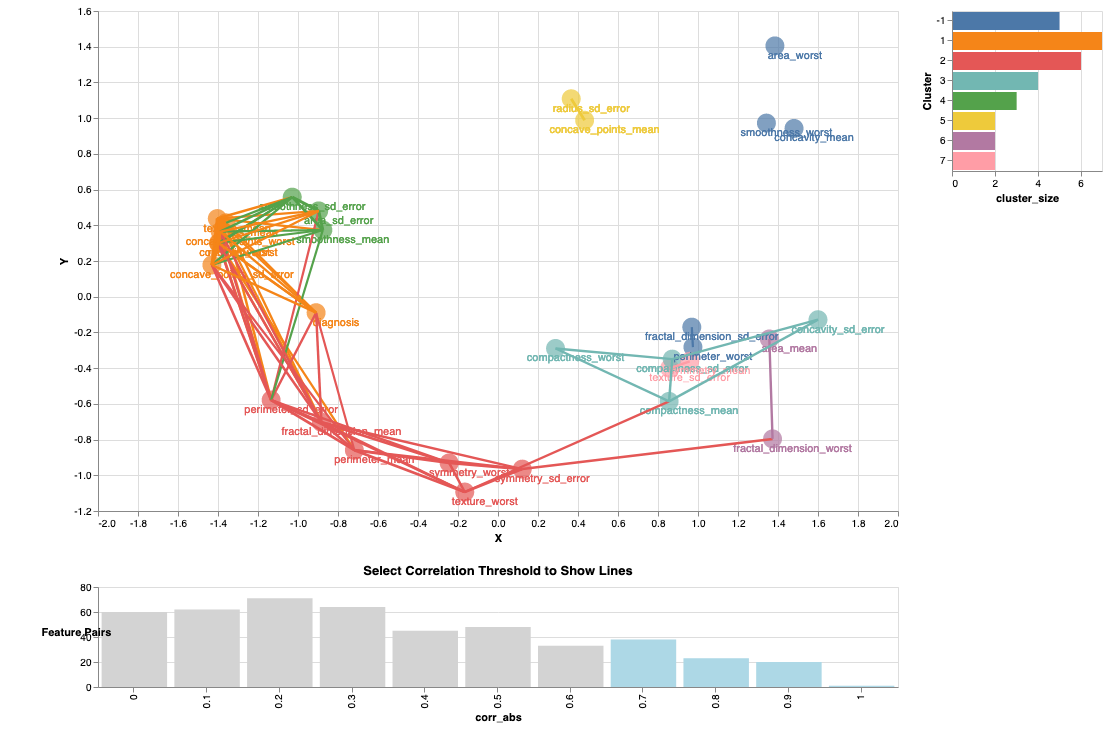

In [222]:
visualize_feature_correlation(breast_cancer_df, "clusters")

### TO DO
- ability to pass in your own clusters
- give -1 cluster a name
- melt clusters and turn to lookup
- fix javascript
- try bigger dataset